In [12]:
import sys
print(sys.executable)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from textblob import TextBlob 

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 250)

# --- CORRECTED STOCK TICKER ---
# We are choosing a stock that we know is frequent in our news dataset.
STOCK_TICKER = 'NVDA'

# --- Load News Data ---
news_df = pd.read_csv('../data/raw_analyst_ratings.csv')
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.date

# --- CORRECTED VARIABLE NAME (Good Practice) ---
# Filter for only the news related to our chosen stock.
ticker_news_df = news_df[news_df['stock'] == STOCK_TICKER].copy()
print(f"Loaded {len(ticker_news_df)} news articles for {STOCK_TICKER}.")

# --- Load Stock Data ---
zip_file_path = '../data/yfinance_data.zip'
stock_file_name = f'yfinance_data/{STOCK_TICKER}_historical_data.csv'
try:
    with ZipFile(zip_file_path) as z:
        with z.open(stock_file_name) as f:
            stock_df = pd.read_csv(f)
    # Prepare stock data
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    stock_df.set_index('Date', inplace=True)
    stock_df.rename(columns={'Close': 'close'}, inplace=True)
    print(f"Loaded {len(stock_df)} days of stock data for {STOCK_TICKER}.")
except KeyError:
    print(f"\nERROR: Could not find stock data for {STOCK_TICKER} in the zip file.")
    print("Please choose another stock from the list.")

d:\Tenx\.venv\Scripts\python.exe
Loaded 3146 news articles for NVDA.
Loaded 6421 days of stock data for NVDA.


In [16]:
merged_df = pd.merge(
    ticker_news_df, 
    stock_df[['close']], 
    left_on='date', 
    right_index=True,
    how='inner'
)

print(f"Merged DataFrame contains {len(merged_df)} entries.")
merged_df.head()

Merged DataFrame contains 9 entries.


,Unnamed: 0,headline,url,publisher,date,stock,close
924271,929039,Shares of several technology companies are trading higher on continued volatility despite market weakness. The sector sold off recently as other sectors gained amid US economic reopening and appears to be rebounding.,https://www.benzinga.com/wiim/20/06/16224173/shares-of-several-technology-companies-are-trading-higher-on-continued-volatility-despite-market-wea,Benzinga Newsdesk,2020-06-10,NVDA,9.36675
924272,929040,Afternoon Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/16223572/afternoon-market-stats-in-5-minutes,Benzinga Insights,2020-06-10,NVDA,9.36675
924273,929041,Morning Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/16221744/morning-market-stats-in-5-minutes,Benzinga Insights,2020-06-10,NVDA,9.36675
924274,929042,Shares of several technology companies are trading higher despite market weakness. The sector recently experienced some welling and appears to be rebounding following dip.,https://www.benzinga.com/wiim/20/06/16214789/shares-of-several-technology-companies-are-trading-higher-despite-market-weakness-the-sector-recentl,Benzinga Newsdesk,2020-06-09,NVDA,9.04600
924275,929043,Afternoon Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/16203190/afternoon-market-stats-in-5-minutes,Benzinga Insights,2020-06-08,NVDA,8.80500


In [17]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

merged_df['sentiment'] = merged_df['headline'].apply(get_sentiment)

merged_df[['headline', 'sentiment', 'close']].head()

,headline,sentiment,close
924271,Shares of several technology companies are trading higher on continued volatility despite market weakness. The sector sold off recently as other sectors gained amid US economic reopening and appears to be rebounding.,0.08125,9.36675
924272,Afternoon Market Stats in 5 Minutes,0.00000,9.36675
924273,Morning Market Stats in 5 Minutes,0.00000,9.36675
924274,Shares of several technology companies are trading higher despite market weakness. The sector recently experienced some welling and appears to be rebounding following dip.,0.26250,9.04600
924275,Afternoon Market Stats in 5 Minutes,0.00000,8.80500


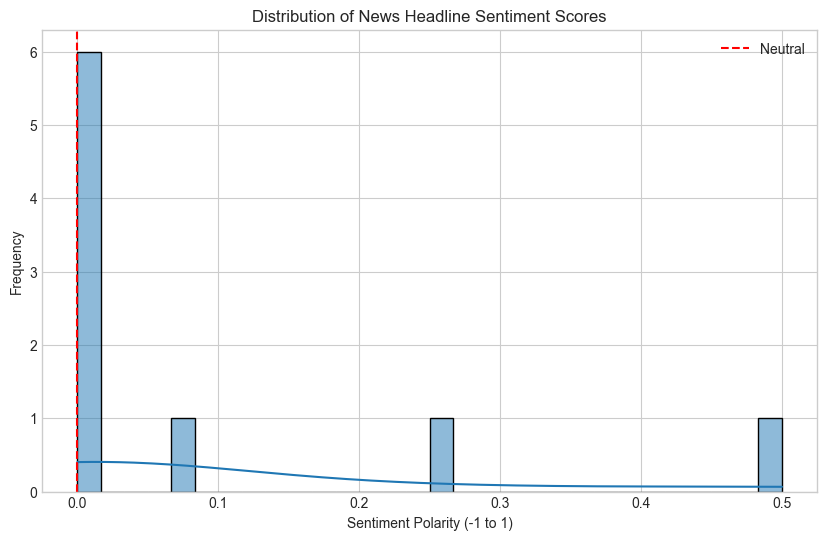

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['sentiment'], bins=30, kde=True)
plt.title('Distribution of News Headline Sentiment Scores')
plt.xlabel('Sentiment Polarity (-1 to 1)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Neutral')
plt.legend()
plt.show()

In [19]:
merged_df['daily_return'] = merged_df['close'].pct_change()

daily_sentiment = merged_df.groupby('date')['sentiment'].mean()

correlation_df = merged_df.groupby('date').agg({
    'sentiment': 'mean',
    'daily_return': 'mean' 
}).rename(columns={'sentiment': 'mean_sentiment'})

correlation_df.dropna(inplace=True)

correlation_df.head()

,mean_sentiment,daily_return
date,,
2020-06-02,0.250000,0.001150
2020-06-08,0.000000,-0.008881
2020-06-09,0.262500,-0.034243
2020-06-10,0.027083,0.000000


Pearson Correlation between Mean Daily Sentiment and Daily Stock Returns: -0.4377


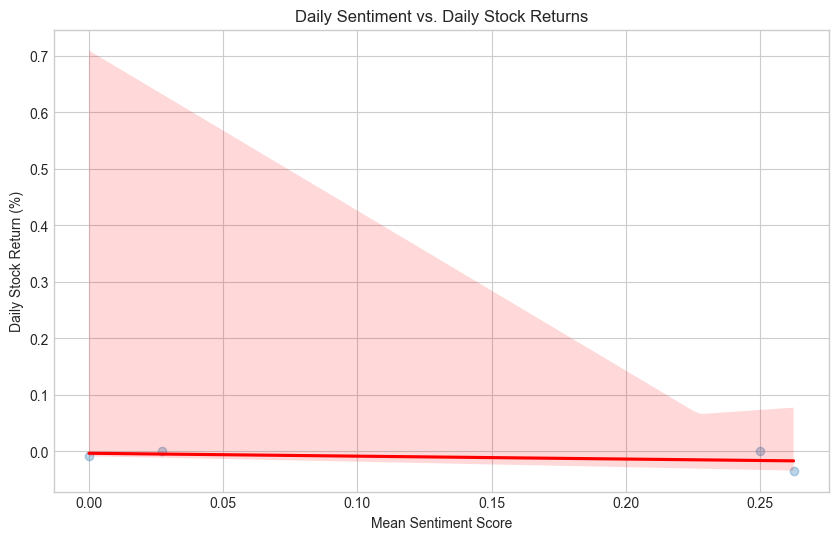

In [20]:
correlation = correlation_df['mean_sentiment'].corr(correlation_df['daily_return'])

print(f"Pearson Correlation between Mean Daily Sentiment and Daily Stock Returns: {correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(data=correlation_df, x='mean_sentiment', y='daily_return', 
            line_kws={"color": "red"}, scatter_kws={'alpha':0.3})
plt.title('Daily Sentiment vs. Daily Stock Returns')
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Daily Stock Return (%)')
plt.grid(True)
plt.show()